In [1]:
from leaderfollower.file_helper import loadTrialData, loadConfigData, loadBatch
from leaderfollower.data_helpers import getEvalFitnesses
from leaderfollower.plot_helpers import plotJointTrajectory, plotBatchPerformance, PerformanceMetric

In [2]:
"""Function definitions for plotting"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import numpy as np
from typing import List, Dict, Optional
from enum import IntEnum

from leaderfollower.data_helpers import getEvalStatistics, getBestStatistics

class PerformanceMetric(IntEnum):
    BestTrainingTeam = 0
    EvaluationTeam = 1

def plotStatisticsAvg(avg, color):
    num_generations_arr = np.arange(avg.shape[0])
    plt.plot(num_generations_arr, avg, color=color, linewidth=4)

def plotStatisticsRange(upper_dev, lower_dev, upper_range, lower_range, color, plot_min_max_range=False):
    num_generations_arr = np.arange(upper_dev.shape[0])
    plt.fill_between(num_generations_arr, upper_dev.flatten(), lower_dev.flatten(), alpha=0.2, color=color)
    if plot_min_max_range:
        plt.fill_between(num_generations_arr, upper_range.flatten(), lower_range.flatten(), alpha=0.2, color=color)

def plotBatchPerformance(trial_datas_G: Optional[dict], trial_datas_D: Optional[dict], trial_datas_Dfollow: Optional[dict], \
                        plot_min_max_range: bool, computername: str, performance_metric: PerformanceMetric):
    plt.figure(0)

    num_stat_runs = len(trial_datas_G)

    if performance_metric.value == PerformanceMetric.BestTrainingTeam.value:
        getStatistics = getBestStatistics
        title = "Best Training Team"
    elif performance_metric.value == PerformanceMetric.EvaluationTeam.value:
        getStatistics = getEvalStatistics
        title = "Evaluation Team"

    # Get statistics for different reward structures
    # We plot the baselines first so that D-Indirect is on the top layer
    legend = []
    if trial_datas_G is not None:
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_G, lower_G = getStatistics(trial_datas_G)
        plotStatisticsAvg(avg_G, color='tab:blue')
        legend.append("$G$")
        num_generations_arr = np.arange(avg_G.shape[0])

    if trial_datas_D is not None:
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_D, lower_D = getStatistics(trial_datas_D)
        plotStatisticsAvg(avg_D, color='tab:orange')
        legend.append("$D$")
        num_generations_arr = np.arange(avg_D.shape[0])

    if trial_datas_Dfollow is not None:
        avg_Df, std_dev_Df, upper_err_Df, lower_err_Df, upper_Df, lower_Df = getStatistics(trial_datas_Dfollow)
        plotStatisticsAvg(avg_Df, color='tab:green')
        legend.append(r'$D^I$')
        num_generations_arr = np.arange(avg_Df.shape[0])

    # Automatically figure out how many generations were in here
    plt.ylim([0,1.01])
    plt.xlim([0,len(num_generations_arr)-1])

    # Add the standard error or min max plotting
    if trial_datas_G is not None: 
        plotStatisticsRange(upper_err_G, lower_err_G, upper_G, lower_G, 'tab:blue', plot_min_max_range)
    if trial_datas_D is not None:
        plotStatisticsRange(upper_err_D, lower_err_D, upper_D, lower_D, 'tab:orange', plot_min_max_range)
    if trial_datas_Dfollow is not None:
        plotStatisticsRange(upper_err_Df, lower_err_Df, upper_Df, lower_Df, 'tab:green', plot_min_max_range)

    plt.legend(legend, fontsize=20, loc="lower right")

    # plt.legend(["$G$", "$D$", r'$D_{follow}$'])

    plt.xlabel("Generations", fontsize=20)
    plt.ylabel("Performance", fontsize=20)
    plt.xticks(ticks=None, labels=None, fontsize=15)
    plt.yticks(ticks=None, labels=None, fontsize=15)
    plt.grid()
    # plt.title(title)

    # plt.xlim([0,150])

    plot_save_name = computername + " | stat_runs "+str(num_stat_runs)+" | "+title+" |"
    if trial_datas_G:
        plot_save_name += " G"
    if trial_datas_D:
        plot_save_name += " D"
    if trial_datas_Dfollow:
        plot_save_name += " Df"
    if plot_min_max_range:
        plot_save_name += " | full range"
    else:
        plot_save_name += " | std err"

    png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
    svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

    print("Saving plot as ", png_plot_save_name)
    print("Saving plot as ", svg_plot_save_name)
    plt.savefig(png_plot_save_name)
    plt.savefig(svg_plot_save_name)

    plt.show()

def scaleRGB(rgb_values: List[int]):
    scaled_values = []
    for value in rgb_values:
        scaled_values.append(float(value)/255.)
    return tuple(scaled_values)

def plotJointTrajectorySubplot(trial_data: List[Dict], config: Dict, ax: Axes, generation: Optional[int], team_id: int | str, individual_plot: bool = True, sample_frequency: int = 1, show_legend:bool = True):
    if generation is None:
        generation = config["num_generations"]
    if team_id == "Eval":
        # Get the joint trajectory of the evaluation team
        # joint_trajectory = np.array('final_evaluation_teams'[generation].joint_trajectory).tolist()
        joint_trajectory = np.array(trial_data[generation]["evaluation_team"]["joint_trajectory"]).tolist()
    else:
        # First get the joint trajectory for this particular generation
        # Each element is a snapshot of all agent positions at a particular point in time
        # teams_in_evaluations is a global variable thanks to how python does things
        # joint_trajectory = np.array(teams_in_evaluations[generation][team_id].joint_trajectory).tolist()
        joint_trajectory = np.array(trial_data[generation]["training_teams"]["team_"+str(team_id)]["joint_trajectory"]).tolist()
    
    # I need the joint trajectory as a list of trajectories where each trajectory is a list of (x,y) tuples for a particular agent
    num_trajectories = len(joint_trajectory[0])
    list_of_trajectories = [[] for _ in range(num_trajectories)]
    for positions in joint_trajectory:
        for position, trajectory in zip(positions, list_of_trajectories):
            trajectory.append(tuple(position))

    # Now I need to set up variables for the plot

    # Get map dimensions for figuring the x and y limits of the graph
    map_dimensions = config["CCEA"]["config"]["BoidsEnv"]["config"]["map_dimensions"]
    map_dim_x = map_dimensions["x"]
    map_dim_y = map_dimensions["y"]

    # Use map dimensions to figure out correctly proportioned graph size
    # Keep x dimension the same and adjust the y dimension accordingly
    # fig_x = 5.
    # fig_y = fig_x * float(map_dim_y)/float(map_dim_x)

    # Get the number of leaders and followers
    num_leaders = config["CCEA"]["config"]["BoidsEnv"]["config"]["StateBounds"]["num_leaders"]
    num_followers = config["CCEA"]["config"]["BoidsEnv"]["config"]["StateBounds"]["num_followers"]

    # Set up the leader colors for coloring the trajectories
    leader_colors_rgb_raw = config["CCEA"]["config"]["BoidsEnv"]["config"]["Renderer"]["leader_colors"]
    leader_colors_scaled = [scaleRGB(color) for color in leader_colors_rgb_raw]
    leader_colors = []
    for leader_ind in range(num_leaders):
        leader_colors.append(leader_colors_scaled[leader_ind%len(leader_colors_scaled)])

    # Set up follower color
    follower_color = scaleRGB([73, 65, 109])

    # Set up leader color
    # leader_color = leader_colors[0]
    leader_color = scaleRGB([255, 209, 102])

    # Set up colors of agents for all trajectories
    # agent_colors = leader_colors + [follower_color]*num_followers

    # I reverse it so that the leader trajectories are plotted on top
    # for trajectory, agent_color in reversed(list(zip(list_of_trajectories, agent_colors))):
    #     xs, ys = zip(*trajectory)
    #     ax.plot(xs, ys, color=agent_color, marker='P')

    plot_marker_size = 10

    follower_trajectories = list_of_trajectories[num_leaders:]
    for trajectory in follower_trajectories:
        xs, ys = zip(*trajectory)
        ax.plot(xs[::sample_frequency], ys[::sample_frequency], color=follower_color, marker="s", markersize=plot_marker_size)

    leader_trajectories = list_of_trajectories[:num_leaders]
    for trajectory in leader_trajectories:
        xs, ys = zip(*trajectory)
        ax.plot(xs[::sample_frequency], ys[::sample_frequency], color=leader_color, marker="P", markersize=plot_marker_size)

    # Set up poi colors
    # For now just use the observed color because I don't yet save 
    # if a poi has been observed or not, so to determine that we would have to do a rollout or 
    # call some code to compute that
    poi_observed_color = scaleRGB([170, 80, 66]) #redwood color
    # poi_observed_color = scaleRGB([229, 79, 109]) # magenta color
    # poi_unobserved_color = scaleRGB([255, 0, 0])

    # Get the POI positions for the configuration
    # Later on this should plot the poi observation radius also
    poi_positions = config["CCEA"]["config"]["BoidsEnv"]["config"]["POISpawner"]["positions"]
    num_pois = len(poi_positions)
    poi_colors = [poi_observed_color]*num_pois
    for poi_position, poi_color in zip(poi_positions, poi_colors):
        ax.plot(poi_position[0], poi_position[1], marker="^", color=poi_color, markersize=plot_marker_size+5)

    # Add axes labels and a title
    if individual_plot:
        ax.set_xlabel('X', fontsize=20)
        ax.set_ylabel('Y', fontsize=20)
        ax.set_title('Joint Trajectory')

    # Limits according to map dimensions from config
    # ax.set_xlim([0, map_dim_x])
    # ax.set_ylim([0, map_dim_y])

    ax.set_xlim([0, 60])
    ax.set_ylim([0, 60])

    # Custom legend
    # leader_handles = [
    #     Line2D([0], [0], color=leader_color, lw=1) for leader_color in leader_colors
    # ]
    # leader_labels = ["Leader "+str(i+1) for i in range(num_leaders)]

    label_marker_size = 10

    leader_handle = Line2D([0], [0], color=leader_color, lw=1, marker="P", markersize=label_marker_size)
    leader_label = "Leader"

    follower_handle = Line2D([0], [0], color=follower_color, lw=1, marker="s", markersize=label_marker_size)
    follower_label = "Follower"

    poi_handle = Line2D([0], [0], color=poi_observed_color, lw=0, marker="^", markersize=label_marker_size+5)
    poi_label = "POI"

    # handles = leader_handles + [follower_handle] + [poi_handle]
    # labels = leader_labels + [follower_label] + [poi_label]

    handles = [leader_handle, follower_handle, poi_handle]
    labels = [leader_label, follower_label, poi_label]

    if individual_plot and show_legend:
        ax.legend(handles, labels, ncol=1, fontsize=20)

    # Add a grid and make it look pretty
    ax.grid()
    ax.tick_params(
        axis='both',
        which='both',
        top = False,
        bottom = False,
        left = False,
        right = False,
        labelsize=15
    )
    # Give plot a gray background like ggplot.
    ax.set_facecolor('#EBEBEB')
    # Remove border around plot.
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # Style the grid.
    ax.grid(which='major', color='white', linewidth=1.2)
    ax.grid(which='minor', color='white', linewidth=0.6)

    # Set up the ticks for the grid
    xticks = np.linspace(0, int(map_dim_x - (map_dim_x%10)), int(map_dim_x/10.)+1)
    yticks = np.linspace(0, int(map_dim_y - (map_dim_y%10)), int(map_dim_y/10.)+1)

    ax.set_yticks(ticks=yticks, labels=None)
    ax.set_xticks(ticks=xticks, labels=None)

    # Remove labels for individual ticks if option is specified
    if not individual_plot:
        ax.set_xticks(ticks=xticks, labels=[])
        ax.set_yticks(ticks=yticks, labels=[])

    # Show the minor ticks and grid.
    # ax.minorticks_on()
    # Now hide the minor ticks (but leave the gridlines).
    # ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_aspect('equal')
    # ax.set_aspect(1)

def plotJointTrajectory(trial_data: List[Dict], config: Dict, team_id: int | str, generation: Optional[int], plot_save_name: Optional[str] = None, sample_frequency: int = 1, show_legend: bool = True, show_plot: bool = True):
    """High level function for plotting joint trajectories. 
    team_id can be an integer representing the training team to plot
        or it can be the str Eval representing to plot the joint trajectory of the evaluation team
    generation should be an integer specifying which generation's team to use for the joint trajectory
        if generation is None then this should plot the joint trajectories from the last generation
    
    """

    leader_colors = config["CCEA"]["config"]["BoidsEnv"]["config"]["Renderer"]["leader_colors"]
    leader_colors = tuple(np.array(leader_colors)/255)

    if generation is None:
        generation = config["num_generations"]

    if team_id is None:
    # Figure out the grid size to place all of the plots in
        # Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
        num_teams = config["CCEA"]["sub_population_size"]+1
        grid_len = int(np.ceil(np.sqrt(num_teams)))
        fig, axs = plt.subplots(nrows=grid_len, ncols=grid_len, figsize=(15,15), tight_layout=True)
        for team_id, ax in zip(np.arange(num_teams), axs.flat):
            # Add in case for plotting joint trajectory of the evaluation team
            if team_id == num_teams-1:
                team_id = "Eval"
                # Get the fitness of the evaluation team
                team_fitness = trial_data[generation]["evaluation_team"]["team_fitness"][0]
            else:
                # Get the fitness of the training team
                team_fitness = trial_data[generation]["training_teams"]["team_"+str(team_id)]["team_fitness"][0]

            plotJointTrajectorySubplot(trial_data=trial_data, config=config, ax=ax, generation=generation, team_id=team_id, individual_plot=False, sample_frequency=sample_frequency)
            # Objects for a custom legend that just lets me display important metadata
            class AnyObject:
                pass
            class AnyObjectHandler:
                def legend_artist(self, legend, orig_handle, fontsize, handlebox):
                    x0, y0 = handlebox.xdescent, handlebox.ydescent
                    width, height = handlebox.width, handlebox.height
                    patch = mpatches.Rectangle([x0, y0], 0, 0, facecolor='red',
                                            edgecolor='black', hatch='xx', lw=0,
                                            transform=handlebox.get_transform())
                    handlebox.add_artist(patch)
                    return patch
                
            # # Extract the fitness for this particular team
            # team_fitness = teams_in_evaluations[generation][team_id].fitness
            # team_fitness = trial_data[]

            # Format that fitness into a nice str
            fitness_str = f"{team_fitness:.3f}"

            # Custom legend that acts as a label for what team this plot is from
            # fake_handle = Line2D([0], [0], color='white', lw=0)
            fake_handle = AnyObject()
            fake_label = str(team_id) + " | " + fitness_str
            ax.legend([fake_handle], [fake_label], loc='upper right', handler_map={AnyObject: AnyObjectHandler()}, handlelength=-1)
            fig.suptitle("Generation "+str(generation))
        if team_id == "Eval":
            team_id = num_teams+1
        for ax in axs.flat[team_id+1:]:
            ax.tick_params(
                axis='both',
                which='both',
                top = False,
                bottom = False,
                left = False,
                right = False
            )
            ax.set_xticks(ticks=[], labels=[])
            ax.set_yticks(ticks=[], labels=[])
            # Remove border around plot.
            [ax.spines[side].set_visible(False) for side in ax.spines]

        fig.subplots_adjust(wspace=0, hspace=0)

        if show_plot: 
            plt.show()
        pass
    # If team id is specified, then just plot that one joint trajectory
    else:
        # Get map dimensions for figuring the x and y limits of the graph
        map_dimensions = config["CCEA"]["config"]["BoidsEnv"]["config"]["map_dimensions"]
        map_dim_x = map_dimensions["x"]
        map_dim_y = map_dimensions["y"]

        # Use map dimensions to figure out correctly proportioned graph size
        # Keep x dimension the same and adjust the y dimension accordingly
        fig_x = 5.
        fig_y = fig_x * float(map_dim_y)/float(map_dim_x)

        # Set up the plot
        # fig = plt.figure(figsize=(fig_x, fig_y))
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        plotJointTrajectorySubplot(trial_data=trial_data, config=config, ax=ax, generation=generation, team_id=team_id, sample_frequency=sample_frequency, show_legend=show_legend)

        if plot_save_name is not None:
            png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
            svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

            print("Saving plot as ", png_plot_save_name)
            print("Saving plot as ", svg_plot_save_name)
            plt.savefig(png_plot_save_name)
            plt.savefig(svg_plot_save_name)
        
        if show_plot:
            plt.show()

In [4]:
"""Load in all of the data for the evaluation teams for the 10 leaders scattered experiment"""
num_generations, trial_datas_Dfollow, trial_datas_D, trial_datas_G = loadBatch(
    computername="experiment_9b_10leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

Dfollow trials:  ['trial_59', 'trial_58', 'trial_57', 'trial_56', 'trial_55', 'trial_54', 'trial_53', 'trial_52', 'trial_51', 'trial_50', 'trial_49', 'trial_48', 'trial_47', 'trial_46', 'trial_45', 'trial_44', 'trial_43', 'trial_42', 'trial_41', 'trial_40']
D trials:  ['trial_39', 'trial_38', 'trial_37', 'trial_36', 'trial_35', 'trial_34', 'trial_33', 'trial_32', 'trial_31', 'trial_30', 'trial_29', 'trial_28', 'trial_27', 'trial_26', 'trial_25', 'trial_24', 'trial_23', 'trial_22', 'trial_21', 'trial_20']
G trials:  ['trial_19', 'trial_18', 'trial_17', 'trial_16', 'trial_15', 'trial_14', 'trial_13', 'trial_12', 'trial_11', 'trial_10', 'trial_9', 'trial_8', 'trial_7', 'trial_6', 'trial_5', 'trial_4', 'trial_3', 'trial_2', 'trial_1', 'trial_0']


100%|██████████| 501/501 [00:04<00:00, 122.70it/s]


Saving plot as  ../../figures/png/experiment_9b_10leaders | stat_runs 20 | Evaluation Team | G D Df | std err.png
Saving plot as  ../../figures/svg/experiment_9b_10leaders | stat_runs 20 | Evaluation Team | G D Df | std err.svg


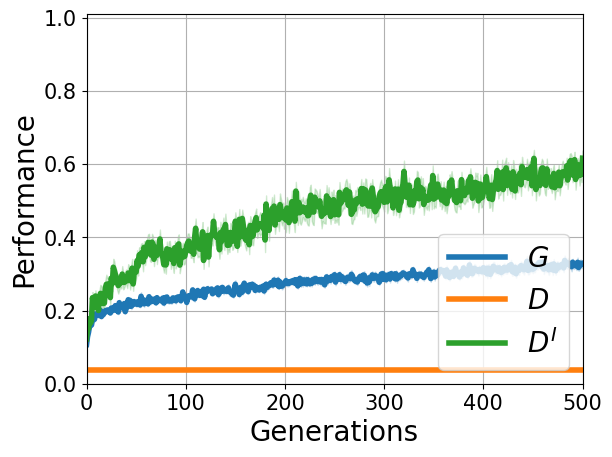

In [5]:
"""Plot the full batch for experiment 9b 10 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric

plotBatchPerformance(
    trial_datas_G = trial_datas_G,
    trial_datas_D = trial_datas_D,
    trial_datas_Dfollow = trial_datas_Dfollow,
    plot_min_max_range=False,
    computername="experiment_9b_10leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
plotBatchPerformance(
    trial_datas_G = trial_datas_G,
    trial_datas_D = trial_datas_D,
    trial_datas_Dfollow = trial_datas_Dfollow,
    plot_min_max_range=True,
    computername="experiment_9b_5leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
# This is to see the performance of DI for the different 5 scattered POI trials
%matplotlib inline
plt.figure(0)

for ind, trial_data_Dfollow in enumerate(trial_datas_Dfollow[:10]):
    eval_performance = []
    for generation in trial_data_Dfollow:
        eval_performance.append(generation["evaluation_team"]["team_fitness"])
    plt.plot(eval_performance)
    plt.legend(list(range(ind+1)))
print(len(trial_datas_Dfollow))

In [ ]:
# This is to see the performance of G for the different 5 scattered POI trials
%matplotlib inline
plt.figure(0)

for ind, trial_data_G in enumerate(trial_datas_G[10:]):
    eval_performance = []
    for generation in trial_data_G:
        eval_performance.append(generation["evaluation_team"]["team_fitness"])
    plt.plot(eval_performance)
    plt.legend(list(range(ind+1)))
print(len(trial_datas_G))

In [ ]:
"""Load in all of the data for the evaluation teams for the 15 leaders scattered experiment"""
num_generations_15b, trial_datas_Dfollow_15b, trial_datas_D_15b, trial_datas_G_15b = loadBatch(
    computername="experiment_9b_15leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

In [ ]:
"""Plot the full batch for experiment 9b 15 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric
%matplotlib inline
plotBatchPerformance(
    trial_datas_G = trial_datas_G_15b,
    trial_datas_D = trial_datas_D_15b,
    trial_datas_Dfollow = trial_datas_Dfollow_15b,
    plot_min_max_range=False,
    computername="experiment_9b_15leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
"""Load in all of the data for the evaluation teams for the 25 leaders scattered experiment"""
num_generations_25b, trial_datas_Dfollow_25b, trial_datas_D_25b, trial_datas_G_25b = loadBatch(
    computername="experiment_9b_25leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

In [ ]:
"""Plot the full batch for experiment 9b 25 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric

plotBatchPerformance(
    trial_datas_G = trial_datas_G_25b,
    trial_datas_D = trial_datas_D_25b,
    trial_datas_Dfollow = trial_datas_Dfollow_25b,
    plot_min_max_range=False,
    computername="experiment_9b_25leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
plotBatchPerformance(
    trial_datas_G = trial_datas_G_25b,
    trial_datas_D = trial_datas_D_25b,
    trial_datas_Dfollow = trial_datas_Dfollow_25b,
    plot_min_max_range=True,
    computername="experiment_9b_25leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
from typing import List, Dict, Optional
from leaderfollower.data_helpers import getEvalStatistics, getBestStatistics
def getSweepStatistics(
        trial_datas_sweep: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generation: Optional[int] = None,
    ):

    if performance_metric.value == PerformanceMetric.BestTrainingTeam.value:
        getStatistics = getBestStatistics
    elif performance_metric.value == PerformanceMetric.EvaluationTeam.value:
        getStatistics = getEvalStatistics

    if generation is None:
        generation = -1

    # This gets the final value for each of these statistics across
    # the different batches
    avg_sweep = []
    std_dev_sweep = []
    upper_err_sweep = []
    lower_err_sweep = []
    upper_range_sweep = []
    lower_range_sweep = []

    for trial_datas in trial_datas_sweep:
        avg, std_dev, upper_err, lower_err, upper_range, lower_range = getStatistics(trial_datas)
        avg_sweep.append(avg[generation])
        std_dev_sweep.append(std_dev[generation])
        upper_err_sweep.append(upper_err[generation])
        lower_err_sweep.append(lower_err[generation])
        upper_range_sweep.append(upper_range[generation])
        lower_range_sweep.append(lower_range[generation])

    return avg_sweep, std_dev_sweep, upper_err_sweep, lower_err_sweep, upper_range_sweep, lower_range_sweep

def getAllSweepStatistics(
        trial_datas_sweep_G: List[List[Dict]],
        trial_datas_sweep_D: List[List[Dict]],
        trial_datas_sweep_Dfollow: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generation: Optional[int] = None       
    ):
    G_sweep_stats = getSweepStatistics(trial_datas_sweep_G, performance_metric, generation)
    D_sweep_stats = getSweepStatistics(trial_datas_sweep_D, performance_metric, generation)
    Dfollow_sweep_stats = getSweepStatistics(trial_datas_sweep_Dfollow, performance_metric, generation)
    return G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats

In [ ]:
def plotAllSweepStatistics(
        trial_datas_sweep_G: List[List[Dict]],
        trial_datas_sweep_D: List[List[Dict]],
        trial_datas_sweep_Dfollow: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generations: Optional[List[int]]=None
    ):
    plt.figure(0)
    legend = []
    for ind, generation in enumerate(generations):
        G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats = getAllSweepStatistics(trial_datas_sweep_G, trial_datas_sweep_D, trial_datas_sweep_Dfollow, performance_metric, generation)
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_range_G, lower_range_G = G_sweep_stats
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_range_D, lower_range_D = D_sweep_stats
        avg_Dfollow, std_dev_Dfollow, upper_err_Dfollow, lower_err_Dfollow, upper_range_Dfollow, lower_range_Dfollow = Dfollow_sweep_stats

        line_style = "-"
        if ind == 0:
            line_style = ":"

        plt.plot(list(range(len(avg_G))), avg_G, color='tab:blue', linestyle=line_style, linewidth=4)
        plt.plot(list(range(len(avg_D))), avg_D, color='tab:orange', linestyle=line_style, linewidth=4)
        plt.plot(list(range(len(avg_Dfollow))), avg_Dfollow, color='tab:green', linestyle=line_style, linewidth=4)
        legend.append(f"$G$, {generation} generations")
        legend.append(f"$D$, {generation} generations")
        legend.append(f"$D^I$, {generation} generations")

    for ind, generation in enumerate(generations):
        G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats = getAllSweepStatistics(trial_datas_sweep_G, trial_datas_sweep_D, trial_datas_sweep_Dfollow, performance_metric, generation)
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_range_G, lower_range_G = G_sweep_stats
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_range_D, lower_range_D = D_sweep_stats
        avg_Dfollow, std_dev_Dfollow, upper_err_Dfollow, lower_err_Dfollow, upper_range_Dfollow, lower_range_Dfollow = Dfollow_sweep_stats

        line_style = "-"
        if ind == 0:
            line_style = ":"

        plt.fill_between(list(range(len(upper_err_G))), np.array(upper_err_G).flatten(), np.array(lower_err_G).flatten(), alpha=0.2, color='tab:blue')
        plt.fill_between(list(range(len(upper_err_D))), np.array(upper_err_D).flatten(), np.array(lower_err_D).flatten(), alpha=0.2, color='tab:orange')
        plt.fill_between(list(range(len(upper_err_Dfollow))), np.array(upper_err_Dfollow).flatten(), np.array(lower_err_Dfollow).flatten(), alpha=0.2, color='tab:green')

        
    plt.legend(legend, fontsize=20)
    plt.ylim([0, 1.01])
    plt.xlim([0,2])
    plt.grid()

    plt.xticks(ticks=[0,1,2], labels=[5,15,25], fontsize=15)
    plt.yticks(ticks=None, labels=None, fontsize=15)

    plot_save_name = "experiment_9a_sweep"

    png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
    svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

    print("Saving plot as ", png_plot_save_name)
    print("Saving plot as ", svg_plot_save_name)
    plt.savefig(png_plot_save_name)
    plt.savefig(svg_plot_save_name)

plotAllSweepStatistics(
    trial_datas_sweep_G = [trial_datas_G, trial_datas_G_15b, trial_datas_G_25b],
    trial_datas_sweep_D = [trial_datas_D, trial_datas_D_15b, trial_datas_D_25b],
    trial_datas_sweep_Dfollow = [trial_datas_Dfollow, trial_datas_Dfollow_15b, trial_datas_Dfollow_25b],
    performance_metric = PerformanceMetric.EvaluationTeam,
    generations = [10, 500]
)

### Plotting Joint Trajectories

In [ ]:
# Plot the individual performances of each G trial
%matplotlib qt
G_performances = []
for trial_data in trial_datas_G_25b:
    performance = [gen_dict["evaluation_team"]["team_fitness"][0] for gen_dict in trial_data]
    G_performances.append(performance)
    plt.plot(performance)

In [ ]:
final_G_performances = [performance[-1] for performance in G_performances]
G_ids = list(range(len(final_G_performances)))
print(final_G_performances)
print(G_ids)

In [ ]:
print(np.average(final_G_performances))

In [ ]:
sfinal_G_performances = sorted(final_G_performances)
sG_ids = [G_id for _, G_id in sorted(zip(final_G_performances, G_ids), key=lambda pair: pair[0])]

In [ ]:
print(sfinal_G_performances)
print(sG_ids)

In [ ]:
print("unsorted")
for p, i in zip(final_G_performances, G_ids):
    print(i, p)
print("sorted")
for p, i in zip(sfinal_G_performances, sG_ids):
    print(i,p)

# Highest scoring joint policies are at the end of the list

In [ ]:
# So now I need to look through the training for the G at the 75th percintile, which in this list should be element 14
print(sfinal_G_performances[14], sG_ids[14])

In [ ]:
# So the top joint policy in the 75th percentile is id 10 with final score of .243
# Looks right from performance curve for G on the 25 pois case. This is actuall pretty close to the mean
# Ok so now I should plot the joint trajectory for the evaluation team for this at different points in time
# Careful with variable names here - lots of things changing quickly, things may be named wrong
trial_data_G_14 = trial_datas_G_25b[10]
config_data_G = loadConfigData(trialname="trial_14", computername="experiment_9b_25leaders", abs_results_path="/home/gonzaeve/boids/leader-follower")

In [ ]:
plotJointTrajectory(
    trial_data=trial_data_G_14,
    config=config_data_G,
    team_id="Eval",
    generation=0,
    sample_frequency=10,
    plot_save_name="25leaders_scattered_G_trial_14_Gen0_evaljt"
)

In [ ]:
plotJointTrajectory(
    trial_data=trial_data_G_14,
    config=config_data_G,
    team_id="Eval",
    generation=1,
    sample_frequency=10,
    plot_save_name="25leaders_scattered_G_trial_14_Gen1_evaljt"
)

In [ ]:
plotJointTrajectory(
    trial_data=trial_data_G_14,
    config=config_data_G,
    team_id="Eval",
    generation=2,
    sample_frequency=10,
    plot_save_name="25leaders_scattered_G_trial_14_Gen2_evaljt"
)

In [ ]:
plotJointTrajectory(
    trial_data=trial_data_G_14,
    config=config_data_G,
    team_id="Eval",
    generation=3,
    sample_frequency=10,
    plot_save_name="25leaders_scattered_G_trial_14_Gen3_evaljt"
)

In [ ]:
#Hmmmm. time to animate
%matplotlib inline
for g in range(len(trial_data_G_14)):
    plotJointTrajectory(
        trial_data=trial_data_G_14,
        config=config_data_G,
        team_id="Eval",
        generation=g,
        sample_frequency=10,
        plot_save_name=f"25leaders_scattered_G_trial_10_Gen{g}_evaljt",
        show_legend=False,
        show_plot=False
    )

In [ ]:
# I'm going to do the same with DI
DI_performances = []
for trial_data in trial_datas_Dfollow_25b:
    performance = [gen_dict["evaluation_team"]["team_fitness"][0] for gen_dict in trial_data]
    DI_performances.append(performance)
    plt.plot(performance)

In [ ]:
final_DI_performances = [performance[-1] for performance in DI_performances]
DI_ids = list(range(len(final_DI_performances)))

sfinal_DI_performances = sorted(final_DI_performances)
sDI_ids = [DI_id for _, DI_id in sorted(zip(final_DI_performances, DI_ids), key=lambda pair: pair[0])]
for p, i in zip(sfinal_DI_performances, sDI_ids):
    print(i,p)

In [ ]:
print(np.average(final_DI_performances))

In [ ]:
print(sDI_ids[14], sfinal_DI_performances[14])
# Wow that's over half the score of the 75th percentile with G

In [ ]:
trial_data_DI_2 = trial_datas_G_25b[2]
config_data_DI = loadConfigData(trialname="trial_2", computername="experiment_9b_25leaders", abs_results_path="/home/gonzaeve/boids/leader-follower")

In [ ]:
# time to animate
%matplotlib inline
for g in range(len(trial_data_DI_2)):
    plotJointTrajectory(
        trial_data=trial_data_DI_2,
        config=config_data_DI,
        team_id="Eval",
        generation=g,
        sample_frequency=10,
        plot_save_name=f"25leaders_scattered_DI_trial_2_Gen{g}_evaljt",
        show_legend=False,
        show_plot=False
    )

In [ ]:
# Looking at the joint trajectories for the 25 pois case, it is actually very difficult to see how DI is helping the system learn
# It is strange though that so many of the leaders just sit there
# I feel like maybe one of theose heuristics measuring leader-follower influence is a good idea to incorporate
# Maybe do something like
# In an episode, look at each leader
# See if that leader was within 5 units (influence radius) of a follower at a timestep
# Aggregate the amount of timesteps a leader was influencing at least one follower
# Average accross statistical runs
# Compare accross different methods G, DI, D

In [6]:
# I think it would be worthwhile though to look at the joint trajectories for the 5 pois case because I know DI can reach a score of 1.0 on it
# And G does not (at least within 500 generations of training)
# I bet this is where I can demonstrate how DI cleans up messy feedback

# Let's see how much I can streamline into a single cell

def get75thPercentileTrial(trial_datas: List[Dict], plot_performance: bool = True):
    # 1) Get all of the performances over generations for each trial
    all_performances = []
    for trial_data in trial_datas:
        performance = [gen_dict["evaluation_team"]["team_fitness"][0] for gen_dict in trial_data]
        all_performances.append(performance)
        if plot_performance:
            plt.plot(performance)
            plt.title("Performance")

    # 2) Get the final performances at the end of training and generate corresponding ids for each final performance
    final_performances = [performance[-1] for performance in all_performances]
    ids = list(range(len(final_performances)))
    print("Final Performances")
    print(final_performances)
    print(ids)

    # 3) Sort the final performances and corresponding ids. Lowest performing joint-policy is 0. Highest performing jp is last element
    sorted_scores = sorted(final_performances)
    sorted_ids = [id_ for _, id_ in sorted(zip(final_performances, ids), key=lambda pair: pair[0])]
    print("Sorted Performances")
    print(sorted_scores)
    print(sorted_ids)

    # 4) Get the top of the 75th percentile. There are 20 trials indexed at 0, so this is the 14th highest score
    chosen_score = sorted_scores[14]
    chosen_id = sorted_ids[14]
    print("75th Percentile Chosen Score")
    print("id, score")
    print(chosen_id, chosen_score)

    # 5) Get this trial from the list of all the trials
    chosen_trial_data = trial_datas[chosen_id]

    return chosen_trial_data

def plotTrialEvalJt(trial_data, config_data, plot_save_name_prepend):
    # 6) Plot the joint trajectory learned at each generation. Each a as a seperate image
    for g in range(len(trial_data)):
        plotJointTrajectory(
            trial_data=trial_data,
            config=config_data,
            team_id="Eval",
            generation=g,
            sample_frequency=10,
            plot_save_name=plot_save_name_prepend+f"_Gen{g}", # f"25leaders_scattered_DI_trial_2_Gen{g}_evaljt",
            show_legend=False,
            show_plot=False
        )

def plot75thPercentile(
        trial_datas,
        config_data,
        plot_save_name_prepend
    ):
    chosen_trial = get75thPercentileTrial(trial_datas)
    plotTrialEvalJt(trial_data=chosen_trial, config_data=config_data, plot_save_name_prepend=plot_save_name_prepend)

In [ ]:
# 5 leaders case, 5 scattered POIs, G and DI
config_data = loadConfigData(trialname="trial_0", computername="experiment_9b_5leaders", abs_results_path="/home/gonzaeve/boids/leader-follower")
plot75thPercentile(
    trial_datas=trial_datas_G,
    config_data=config_data,
    plot_save_name_prepend="5leaders_9b_G_evaljt_75thpercentile"
)
plot75thPercentile(
    trial_datas=trial_datas_Dfollow,
    config_data=config_data,
    plot_save_name_prepend="5leaders_9b_DI_evaljt_75thpercentile"
)

In [9]:
# Get the 75th percentile for the 5 scattered POIs
trial_data_G_75th = get75thPercentileTrial(trial_datas=trial_datas_G, plot_performance=False)
trial_data_DI_75th = get75thPercentileTrial(trial_datas=trial_datas_Dfollow, plot_performance=False)
config_data = loadConfigData(trialname="trial_0", computername="experiment_9b_5leaders", abs_results_path="/home/gonzaeve/boids/leader-follower")

Final Performances
[0.4153, 0.637, 0.3657, 0.451, 0.654, 0.4502, 0.57, 0.559, 0.636, 0.5166, 0.4773, 0.4973, 0.3496, 0.6367, 0.598, 0.434, 0.635, 0.3767, 0.4224, 0.4395]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Sorted Performances
[0.3496, 0.3657, 0.3767, 0.4153, 0.4224, 0.434, 0.4395, 0.4502, 0.451, 0.4773, 0.4973, 0.5166, 0.559, 0.57, 0.598, 0.635, 0.636, 0.6367, 0.637, 0.654]
[12, 2, 17, 0, 18, 15, 19, 5, 3, 10, 11, 9, 7, 6, 14, 16, 8, 13, 1, 4]
75th Percentile Chosen Score
id, score
14 0.598
Final Performances
[1.0, 1.0, 0.623, 0.441, 0.825, 0.828, 0.7534, 1.0, 0.612, 0.829, 0.829, 0.5127, 0.8325, 0.3665, 0.663, 0.718, 1.0, 0.7124, 0.8423, 1.0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Sorted Performances
[0.3665, 0.441, 0.5127, 0.612, 0.623, 0.663, 0.7124, 0.718, 0.7534, 0.825, 0.828, 0.829, 0.829, 0.8325, 0.8423, 1.0, 1.0, 1.0, 1.0, 1.0]
[13, 3, 11, 8, 2, 14, 17, 15, 6, 4, 5, 9, 10, 12, 18, 0, 1, 7, 16, 19]
75th Percentil

In [10]:
# Plot those joint trajectories as svgs at 50, 250, 500 generations
%matplotlib qt

for g in [50, 250, 500]:
    # Plot G joint trajectories at 50, 250, 500 gens
    plot_save_name_prepend = "G_75th_percentile_jt_exp9b_5leaders"
    plotJointTrajectory(
        trial_data=trial_data_G_75th,
        config=config_data,
        team_id="Eval",
        generation=g,
        sample_frequency=20,
        plot_save_name=plot_save_name_prepend+f"_Gen{g}",
        show_legend=True,
        show_plot=False
    )
    # Plot DI joint trajectories at 50, 250, 500 gens
    plot_save_name_prepend = "DI_75th_percentile_jt_exp9b_5leaders"
    plotJointTrajectory(
        trial_data=trial_data_DI_75th,
        config=config_data,
        team_id="Eval",
        generation=g,
        sample_frequency=20,
        plot_save_name=plot_save_name_prepend+f"_Gen{g}",
        show_legend=True,
        show_plot=False
    )

Saving plot as  ../../figures/png/G_75th_percentile_jt_exp9b_5leaders__Gen50.png
Saving plot as  ../../figures/svg/G_75th_percentile_jt_exp9b_5leaders__Gen50.svg
Saving plot as  ../../figures/png/DI_75th_percentile_jt_exp9b_5leaders__Gen50.png
Saving plot as  ../../figures/svg/DI_75th_percentile_jt_exp9b_5leaders__Gen50.svg
Saving plot as  ../../figures/png/G_75th_percentile_jt_exp9b_5leaders__Gen250.png
Saving plot as  ../../figures/svg/G_75th_percentile_jt_exp9b_5leaders__Gen250.svg
Saving plot as  ../../figures/png/DI_75th_percentile_jt_exp9b_5leaders__Gen250.png
Saving plot as  ../../figures/svg/DI_75th_percentile_jt_exp9b_5leaders__Gen250.svg
Saving plot as  ../../figures/png/G_75th_percentile_jt_exp9b_5leaders__Gen500.png
Saving plot as  ../../figures/svg/G_75th_percentile_jt_exp9b_5leaders__Gen500.svg
Saving plot as  ../../figures/png/DI_75th_percentile_jt_exp9b_5leaders__Gen500.png
Saving plot as  ../../figures/svg/DI_75th_percentile_jt_exp9b_5leaders__Gen500.svg


### Bar Graph of Final Performance

In [ ]:
# Plot the bar graph for the final performances of these trials
%matplotlib inline 
# for quick iteration
# %matplotlib qt for closer inspection

# Get the eval statistics for the first set of experiments and plot them in a bar graph

num_var_arr = np.arange(3)
space = 0.1 # space between (different batches of bar plots?)
# total_width = (0.2*4) + (space*3) # change 4 to be the number of lines you have per group, lines - 1 for space
total_width = (0.2*3) + (space*3)
# I think since I am only plotting G, DI, and D, then I should change 4->3
pos = num_var_arr * (total_width + space)

# Start the legend now and build it out as we plot
legend = []

# Get the statistics for the sweep. These are the statistics across the trials at a particular generation
trial_datas_sweep_G = [trial_datas_G, trial_datas_G_15b, trial_datas_G_25b]
trial_datas_sweep_D = [trial_datas_D, trial_datas_D_15b, trial_datas_D_25b]
trial_datas_sweep_Dfollow = [trial_datas_Dfollow, trial_datas_Dfollow_15b, trial_datas_Dfollow_25b]


# print(len(trial_datas_sweep_G))
# print(trial_datas_sweep_G[0])
# print(type(trial_datas_sweep_G))
# print(trial_datas_sweep_G)

G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats = \
    getAllSweepStatistics(trial_datas_sweep_G, trial_datas_sweep_D, trial_datas_sweep_Dfollow, PerformanceMetric.EvaluationTeam, 500)

# Break down the stats into avg, err, etc
avg_G, std_dev_G, upper_err_G, lower_err_G, upper_range_G, lower_range_G = G_sweep_stats
avg_D, std_dev_D, upper_err_D, lower_err_D, upper_range_D, lower_range_D = D_sweep_stats
avg_Dfollow, std_dev_Dfollow, upper_err_Dfollow, lower_err_Dfollow, upper_range_Dfollow, lower_range_Dfollow = Dfollow_sweep_stats

# Convert everything into the appropriate data types
def convert(list_of_arrays):
    return np.array([a[0] for a in list_of_arrays])

lower_err_G = convert(lower_err_G)
upper_err_G = convert(upper_err_G)
avg_G = convert(avg_G)

lower_err_D = convert(lower_err_D)
upper_err_D = convert(upper_err_D)
avg_D = convert(avg_D)

lower_err_Dfollow = convert(lower_err_Dfollow)
upper_err_Dfollow = convert(upper_err_Dfollow)
avg_Dfollow = convert(avg_Dfollow)

# Start plotting

# Plot G
pos_G = pos+0.2
plt.vlines(pos_G, lower_err_G, upper_err_G, linestyles="-", colors="black", linewidth=2)
plt.plot([pos_G-0.05, pos_G + 0.05], [lower_err_G, lower_err_G], color="black", linewidth=2)
plt.plot([pos_G-0.05, pos_G + 0.05], [upper_err_G, upper_err_G], color="black", linewidth=2)
plt.bar(pos_G, avg_G, color='tab:blue', width=0.2)
legend.append("$G$")

# Plot D
pos_D = pos
plt.vlines(pos_D, lower_err_D, upper_err_D, linestyles="-", colors="black", linewidth=2)
plt.plot([pos_D-0.05, pos_D + 0.05], [lower_err_D, lower_err_D], color="black", linewidth=2)
plt.plot([pos_D-0.05, pos_D + 0.05], [upper_err_D, upper_err_D], color="black", linewidth=2)
plt.bar(pos_D, avg_D, color='tab:orange', width=0.2)
legend.append("$D$")

# Plot DI
pos_Dfollow = pos_G+0.2
plt.vlines(pos_Dfollow, lower_err_Dfollow, upper_err_Dfollow, linestyles="-", colors="black", linewidth=2)
plt.plot([pos_Dfollow-0.05, pos_Dfollow + 0.05], [lower_err_Dfollow, lower_err_Dfollow], color="black", linewidth=2)
plt.plot([pos_Dfollow-0.05, pos_Dfollow + 0.05], [upper_err_Dfollow, upper_err_Dfollow], color="black", linewidth=2)
plt.bar(pos_Dfollow, avg_Dfollow, color='tab:green', width=0.2)
legend.append(r'$D_{Indirect}$')

leg = plt.legend(legend, fontsize=20, loc="upper right")
# legend becomes black unless you manually modify it
leg.legendHandles[0].set_color("tab:blue")
leg.legendHandles[1].set_color("tab:orange")
leg.legendHandles[2].set_color("tab:green")

plt.xticks(pos + 0.2, ["5", "15", "25"], fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.ylim([0,1.01])

plot_save_name = "experiment_9b_sweep_bar_plot"
png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

plt.savefig(svg_plot_save_name, format="svg")
plt.savefig(png_plot_save_name)

plt.show()
